In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f

from time import time
import numpy as np

from matplotlib import pyplot
import matplotlib as mpl
%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()
print('cuda', use_cuda)

cuda True


In [12]:
image_size = 28 * 28
layer1 = 300
output_size = 10

learning_rate = 0.1
iterations = 15000
dropout = 0.5
batch_size = 128

In [13]:
# if not exist, download mnist dataset
train_set = torchvision.datasets.MNIST(root='/tmp', train=True, transform=transforms.ToTensor(), download=True)
test_set = torchvision.datasets.MNIST(root='/tmp', train=False, transform=transforms.ToTensor(), download=True)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
print('total training batches: {}'.format(len(train_loader)))
print('total testing batches: {}'.format(len(test_loader)))

total training batches: 469
total testing batches: 79


In [15]:
def show(image):
    image = image.view(28,28).numpy()
    print(image.shape)
    fig = pyplot.figure(figsize=(1,1))
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    pyplot.show()

(28, 28)


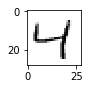

tensor(4)
(28, 28)


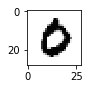

tensor(0)


In [16]:
show(train_set[2][0])
print(train_set[2][1])
show(test_set[3][0])
print(test_set[3][1])

In [39]:
class DenseClassifier(nn.Module):
    def __init__(self):
        super().__init__()        
        self.dense1 = nn.Linear(image_size, layer1)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout)
        self.dense2 = nn.Linear(layer1, output_size)
        
    def forward(self, x):
        x = x.view(-1, image_size)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.drop(x)
        y = self.dense2(x)
        return y
    
    def count_parameters(self, module=None):
        if module is None:
            module = self
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    
model = DenseClassifier()
if use_cuda:
    model = model.cuda()
print(model.count_parameters())

238510


In [40]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [41]:
def test(model, test_loader):
    with torch.no_grad():
        test_loss = []
        accs = []
        errs = 0
        for x,target in test_loader:
            if use_cuda:
                x, target = x.cuda(), target.cuda()
            out = model(x)
            _, pred = f.softmax(out, dim=-1).max(dim=-1)
            match = target == pred
            acc = match.sum().float()/len(match)
            errs += len(match)-match.sum().cpu().item()
            loss = criterion(out, target)
            test_loss.append(loss.cpu().item())
            accs.append(acc.cpu().item())
    print('Errs', errs)
    return np.mean(test_loss), np.mean(accs)

def acc(out, target):
    _, pred = f.softmax(out, dim=-1).max(dim=-1)
    match = target == pred
    return match.sum().float()/len(match)

In [42]:
%%time
i=0
losses = []
accs = []
for _ in range(iterations):
    dt = time()
    train_loss = []
    model.train()
    for batch_idx, (x, target) in enumerate(train_loader):
        i+=1
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.cpu().item())
        losses.append(loss.cpu().item())
        accs.append(acc(out, target))
    if i >= iterations:
        break
    test_loss, accuracy = test(model, test_loader)
    train_loss = np.mean(train_loss)
    print('epoch %d, train loss %.4f, test loss %.4f, acc %.4f, time %3.1fs' % (i, train_loss, test_loss, accuracy, time()-dt))
   

Errs 1045
epoch 469, train loss 0.6310, test loss 0.3581, acc 0.8960, time 5.0s
Errs 800
epoch 938, train loss 0.3207, test loss 0.2711, acc 0.9202, time 4.6s
Errs 667
epoch 1407, train loss 0.2589, test loss 0.2242, acc 0.9333, time 4.6s
Errs 593
epoch 1876, train loss 0.2219, test loss 0.2039, acc 0.9414, time 4.7s
Errs 525
epoch 2345, train loss 0.1951, test loss 0.1795, acc 0.9481, time 4.7s
Errs 520
epoch 2814, train loss 0.1772, test loss 0.1713, acc 0.9486, time 4.6s
Errs 461
epoch 3283, train loss 0.1626, test loss 0.1557, acc 0.9544, time 4.6s
Errs 439
epoch 3752, train loss 0.1514, test loss 0.1473, acc 0.9566, time 4.7s
Errs 424
epoch 4221, train loss 0.1430, test loss 0.1398, acc 0.9581, time 4.8s
Errs 410
epoch 4690, train loss 0.1338, test loss 0.1365, acc 0.9595, time 4.6s
Errs 411
epoch 5159, train loss 0.1267, test loss 0.1299, acc 0.9594, time 4.6s
Errs 395
epoch 5628, train loss 0.1192, test loss 0.1281, acc 0.9609, time 4.7s
Errs 368
epoch 6097, train loss 0.1148, t

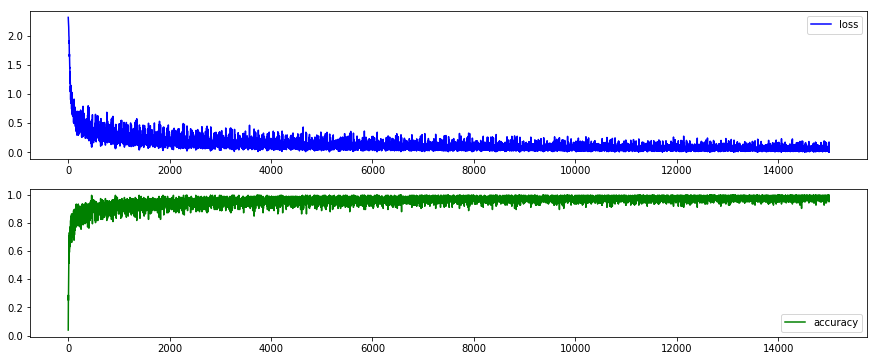

Errs 290
Test accuracy 0.971


In [43]:
fig, ax = pyplot.subplots(2,1, figsize=(15, 6))
ax[0].plot(losses, color='b', label="loss")
ax[1].plot(accs, color='g', label="accuracy")
legend = ax[0].legend(loc='best')
legend = ax[1].legend(loc='best')
pyplot.show()
test_loss, acc = test(model, test_loader)
print('Test accuracy %.3f' % acc)